# Basic stats on the evolution of COVID-19 hospitalizations in departments

In [175]:
%load_ext lab_black
%matplotlib inline

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [208]:
from IPython.display import HTML
import requests
import zipfile
import io
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import geopandas as gpd
import contextily as ctx
from PIL import Image
import warnings

warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

In [209]:
covid_url = (
    "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
)
filter_dep = ["971", "972", "973", "974", "976"]  # only metropolitan France
figsize = (15, 10)

#### <br> Load table with COVID-19 data (figures by dates)

In [210]:
df = pd.read_csv(covid_url, sep=";", parse_dates=True, index_col=2)
df = df.query("sexe == 0")  # sum male/female
df.drop(columns=["sexe"], inplace=True)
df.query("dep not in @filter_dep", inplace=True)
df.sort_index(inplace=True)
df.head(2)

,dep,hosp,rea,rad,dc
jour,,,,,
2020-03-18,01,2,0,1,0
2020-03-18,02,41,10,18,11


In [211]:
last_day = df.index.max()
previous_day = last_day - timedelta(days=1)
print("Evolution from ", previous_day, " to ", last_day)

Evolution from  2020-08-04 00:00:00  to  2020-08-05 00:00:00


#### <br> Build a new dataframe with data from two latest days and the associated evolution

In [212]:
sdf = df.loc[last_day]
sdf.reset_index(inplace=True)
pdf = df.loc[previous_day]
pdf.reset_index(inplace=True)
frame = {"dep": sdf["dep"], "prev_hosp": pdf["hosp"], "last_hosp": sdf["hosp"]}
stats = pd.DataFrame(frame)
stats["diffé"] = stats["last_hosp"] - stats["prev_hosp"]
stats["percent"] = stats["diffé"] / stats["prev_hosp"] * 100
stats.head()

,dep,prev_hosp,last_hosp,diffé,percent
0,01,27,27,0,0.000000
1,02,45,47,2,4.444444
2,03,2,2,0,0.000000
3,04,2,2,0,0.000000
4,05,3,3,0,0.000000


#### <br> Departments with highest number of hospitalizations on the latest day

In [213]:
stats.sort_values(by="last_hosp", ascending=False).head()

,dep,prev_hosp,last_hosp,diffé,percent
92,92,569,578,9,1.581722
93,93,463,461,-2,-0.431965
94,94,304,311,7,2.302632
78,78,281,281,0,0.000000
12,13,278,280,2,0.719424


#### <br> Min, max, mean of evolution between the two latest days (in sum and %)

In [214]:
print(
    "Min: ",
    stats["diffé"].min(),
    " Mean: ",
    stats["diffé"].mean(),
    " Max: ",
    stats["diffé"].max(),
)

Min:  -19  Mean:  -0.14583333333333334  Max:  9


In [215]:
print(
    "Min %: ",
    stats.percent.min(),
    " Mean %: ",
    stats.percent.mean(),
    " Max %: ",
    stats.percent.max(),
)

Min %:  -50.0  Mean %:  0.3301939657680214  Max %:  100.0


#### <br> List of departments with a drecrease of hospitalizations (last two days)

In [216]:
stats.query("diffé < 0")

,dep,prev_hosp,last_hosp,diffé,percent
11,12,6,3,-3,-50.000000
13,14,15,12,-3,-20.000000
19,21,3,2,-1,-33.333333
27,29,7,6,-1,-14.285714
31,31,25,22,-3,-12.000000
35,35,35,33,-2,-5.714286
36,36,73,54,-19,-26.027397
40,40,3,2,-1,-33.333333
44,44,9,8,-1,-11.111111
49,49,38,36,-2,-5.263158


In [217]:
print(stats.query("diffé < 0").shape)

(24, 5)


#### <br> Departments with highest evolution of hospitalizations (total number)

In [218]:
stats.sort_values(by="diffé", ascending=False).head()

,dep,prev_hosp,last_hosp,diffé,percent
92,92,569,578,9,1.581722
94,94,304,311,7,2.302632
57,57,116,122,6,5.172414
5,06,38,43,5,13.157895
68,68,141,145,4,2.836879


#### <br> Departments with highest rate of hospitalizations (%)

In [219]:
stats.sort_values(by="percent", ascending=False).head()

,dep,prev_hosp,last_hosp,diffé,percent
6,07,1,2,1,100.000000
7,08,2,3,1,50.000000
16,17,5,7,2,40.000000
90,90,3,4,1,33.333333
34,34,4,5,1,25.000000


#### <br> Focus on some departments

In [220]:
stats.query("dep=='75'")

,dep,prev_hosp,last_hosp,diffé,percent
75,75,277,272,-5,-1.805054


In [221]:
stats.query("dep=='71'")

,dep,prev_hosp,last_hosp,diffé,percent
71,71,4,3,-1,-25.0


In [222]:
stats.query("dep=='91'")

,dep,prev_hosp,last_hosp,diffé,percent
91,91,242,242,0,0.0


In [223]:
url_dep = "http://osm13.openstreetmap.fr/~cquest/openfla/export/departements-20140306-5m-shp.zip"
local_path = "tmp/"
r = requests.get(url_dep)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)
filenames = [
    y
    for y in sorted(z.namelist())
    for ending in ["dbf", "prj", "shp", "shx"]
    if y.endswith(ending)
]
dbf, prj, shp, shx = [filename for filename in filenames]
fr = gpd.read_file(local_path + shp)  #  + encoding="utf-8" if needed
fr.crs = "epsg:4326"  # {'init': 'epsg:4326'}
met = fr.query("code_insee not in @filter_dep")
met.set_index("code_insee", inplace=True)
met = met["geometry"]

In [224]:
w, s, e, n = met.total_bounds
bck, ext = ctx.bounds2img(w, s, e, n, zoom=tile_zoom, ll=True)

In [225]:
def save_img(df, title, img_name, vmin, vmax):
    gdf = gpd.GeoDataFrame(df, crs={"init": "epsg:4326"})
    gdf_3857 = gdf.to_crs(epsg=3857)  # web mercator
    f, ax = plt.subplots(figsize=figsize)
    ax.imshow(
        bck, extent=ext, interpolation="sinc", aspect="equal"
    )  # load background map
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(
        "right", size="5%", pad=0.1
    )  # GeoPandas trick to adjust the legend bar
    gdf_3857.plot(
        column="diffé",  # truc à tracer
        ax=ax,
        cax=cax,
        alpha=0.75,
        edgecolor="k",
        legend=True,
        cmap=matplotlib.cm.get_cmap("magma_r"),
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_axis_off()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title, fontsize=25)
    plt.savefig(img_name, bbox_inches="tight")  # pad_inches=-0.1 to remove border
    # plt.close(f)

In [226]:
stats["geometry"] = stats["dep"].map(met)

In [227]:
stats.dtypes

dep            object
prev_hosp       int64
last_hosp       int64
diffé           int64
percent       float64
geometry     geometry
dtype: object

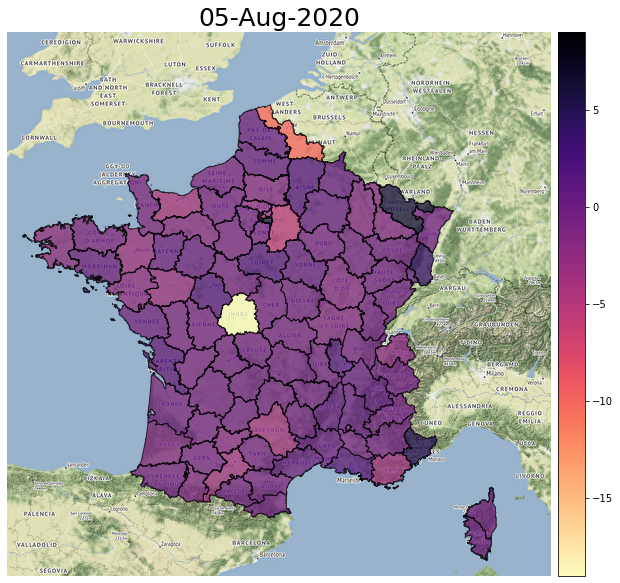

In [228]:
vmin = stats.diffé.min()
vmax = stats.diffé.max()
title = last_day.strftime("%d-%b-%Y")
img_name = title + ".png"
save_img(stats, title, img_name, vmin, vmax)

In [229]:
df2 = stats.set_index("dep", drop=False)

In [230]:
df2.loc["93", :]

dep                                                         93
prev_hosp                                                  463
last_hosp                                                  461
diffé                                                       -2
percent                                              -0.431965
geometry     POLYGON ((2.418994715849627 48.84938657374529,...
Name: 93, dtype: object

## Évolution sur plusieurs jours

In [231]:
df = pd.read_csv(covid_url, sep=";", parse_dates=True, index_col=2)
df = df.query("sexe == 0")  # sum male/female
df.drop(columns=["sexe"], inplace=True)
df.query("dep not in @filter_dep", inplace=True)
df.sort_index(inplace=True)
df.head(2)

,dep,hosp,rea,rad,dc
jour,,,,,
2020-03-18,01,2,0,1,0
2020-03-18,02,41,10,18,11


In [232]:
last_day = df.index.max()
previous_day = last_day - timedelta(days=2)
print("Evolution from ", previous_day, " to ", last_day)

Evolution from  2020-08-03 00:00:00  to  2020-08-05 00:00:00


In [233]:
sdf = df.loc[last_day]
sdf.reset_index(inplace=True)
pdf = df.loc[previous_day]
pdf.reset_index(inplace=True)
frame = {"dep": sdf["dep"], "prev_hosp": pdf["hosp"], "last_hosp": sdf["hosp"]}
stats = pd.DataFrame(frame)
stats["diffé"] = stats["last_hosp"] - stats["prev_hosp"]
stats["percent"] = stats["diffé"] / stats["prev_hosp"] * 100
stats.head()

,dep,prev_hosp,last_hosp,diffé,percent
0,01,28,27,-1,-3.571429
1,02,45,47,2,4.444444
2,03,2,2,0,0.000000
3,04,2,2,0,0.000000
4,05,3,3,0,0.000000


In [234]:
stats["geometry"] = stats["dep"].map(met)

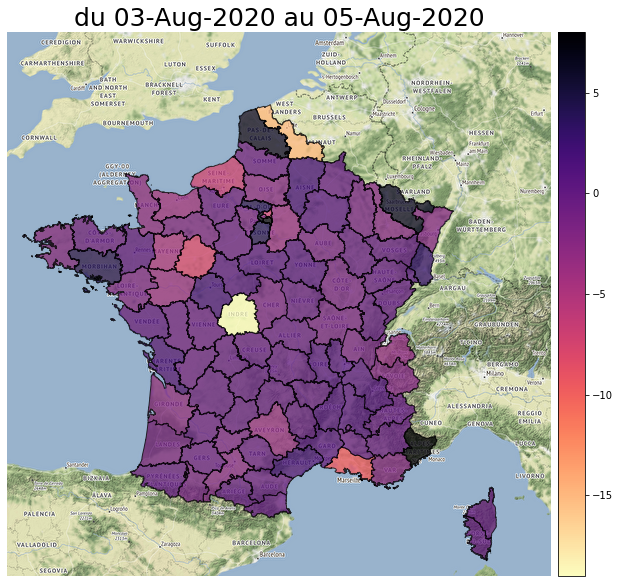

In [235]:
vmin = stats.diffé.min()
vmax = stats.diffé.max()
deb = previous_day.strftime("%d-%b-%Y")
fin = last_day.strftime("%d-%b-%Y")
title = "du " + deb + " au " + fin
img_name = title + ".png"
save_img(stats, title, img_name, vmin, vmax)

In [238]:
stats.query("dep=='36'")

,dep,prev_hosp,last_hosp,diffé,percent,geometry
36,36,73,54,-19,-26.027397,"POLYGON ((2.08872 46.41030, 2.08861 46.41051, ..."


In [243]:
stats.query("dep=='06'").loc[:, stats.columns != "geometry"]

,dep,prev_hosp,last_hosp,diffé,percent
5,06,35,43,8,22.857143
